In [1]:
import sys
sys.path.append("../src")

import logging
from pathlib import Path
import numpy as np
import torch
from natsort import natsorted
from torch import nn
from matplotlib import pyplot as plt
from dataset.data_loading import BasicDataset
from dataset.dataset_interface import DatasetInterface
from networks.UNet.unet_model import UNet
import open3d as o3d
from utils.visualization_utils import visualize_depth, to_rgb
from utils.transformation_utils import imgs_to_pcd, rs_ci, unnormalize_depth
import yaml

root_path = Path("../")

dataset_path = root_path / Path("local_resources/images/calibrated_masked_aug")
logging.info(f"using dataset {dataset_path}")
files = DatasetInterface.get_files_by_path(dataset_path)

INFO - 2022-03-14 18:24:34,414 - 1635306431 - using dataset ../local_resources/images/calibrated_masked_aug


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2022-03-14 18:34:59,932 - 593481130 - counted outliers 4765
INFO - 2022-03-14 18:34:59,968 - 593481130 - counted outliers 5197
INFO - 2022-03-14 18:34:59,998 - 593481130 - Mean depth Input 877.1881103515625
INFO - 2022-03-14 18:34:59,999 - 593481130 - Mean Distance IT 25.7512288901424
INFO - 2022-03-14 18:34:59,999 - 593481130 - Max Distance IT 560.663330078125


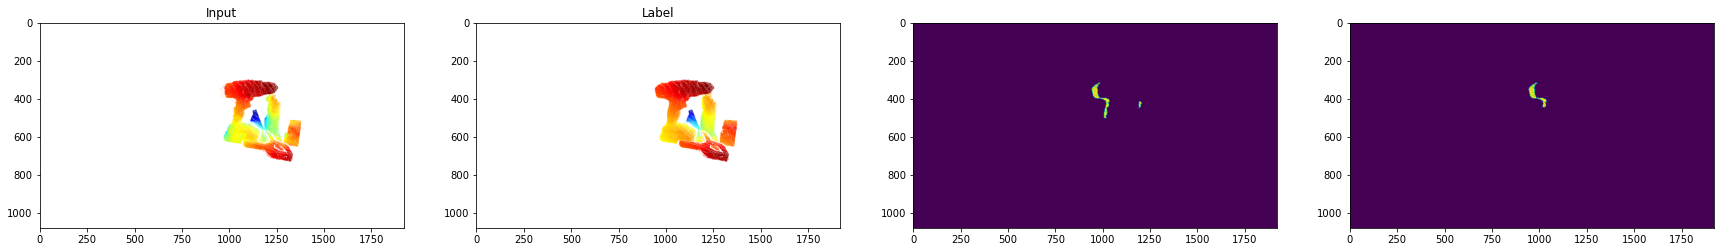

In [20]:
idx = np.random.randint(len(files), size=1).item()
rs_rgb, rs_depth, zv_rgb, zv_depth, mask = DatasetInterface.load(files[idx])

mask = np.squeeze(mask)
nan = np.logical_or(np.isnan(rs_depth), np.isnan(zv_depth))
mask = np.logical_and(mask, ~nan)

input_rgb = rs_rgb
input_depth = rs_depth
real_rgb = zv_rgb
real_depth = zv_depth

# blackout pixel not in mask
input_depth = np.where(mask, input_depth, np.nan)
real_depth = np.where(mask, real_depth, np.nan)

it_diff = np.abs(input_depth - real_depth)
mean_it_diff = np.nansum(it_diff) / np.sum(mask)
max_it_diff = np.nanmax(it_diff)
threshold = 4
outliers_diff = np.where((it_diff > threshold * mean_it_diff)[..., None], [255, 0, 0], [0] * 3).astype(np.uint8)
outliers_diff = np.where((it_diff > threshold * mean_it_diff), input_depth, np.nan)
logging.info(f"counted outliers {np.count_nonzero(~np.isnan(outliers_diff))}")
threshold = 3
outliers_diff = np.where((it_diff > threshold * mean_it_diff)[..., None], [255, 0, 0], [0] * 3).astype(np.uint8)
outliers_diff = np.where((it_diff > threshold * mean_it_diff), input_depth, np.nan)
logging.info(f"counted outliers {np.count_nonzero(~np.isnan(outliers_diff))}")
input_depth = np.where(it_diff > threshold * mean_it_diff, np.nan, input_depth)
it_diff = (((it_diff - np.nanmin(it_diff)) / (np.nanmax(it_diff) - np.nanmin(it_diff))) * 255).astype(np.uint8)
cleaned_it_diff = np.abs(input_depth - real_depth)
cleaned_it_diff = (((cleaned_it_diff - np.nanmin(cleaned_it_diff)) / (np.nanmax(cleaned_it_diff) - np.nanmin(cleaned_it_diff))) * 255).astype(np.uint8)

logging.info(f"Mean depth Input {np.nanmean(input_depth)}")
logging.info(f"Mean Distance IT {mean_it_diff}")
logging.info(f"Max Distance IT {max_it_diff}")

diff_pcd = imgs_to_pcd(input_rgb, it_diff.astype(np.float32), rs_ci)
input_pcd = imgs_to_pcd(input_rgb, input_depth.astype(np.float32), rs_ci)
output_pcd = imgs_to_pcd(real_rgb, real_depth.astype(np.float32), rs_ci)
input_diff_pcd = imgs_to_pcd(visualize_depth(it_diff), input_depth.astype(np.float32), rs_ci)
cleaned_input_diff_pcd = imgs_to_pcd(visualize_depth(cleaned_it_diff), input_depth.astype(np.float32), rs_ci)
# outlier_diff_pcd = imgs_to_pcd(outliers_diff, input_depth.astype(np.float32), rs_ci)
outlier_diff_pcd = imgs_to_pcd(input_rgb, outliers_diff.astype(np.float32), rs_ci)

# o3d.visualization.draw_geometries([diff_pcd])
# o3d.visualization.draw_geometries([outlier_diff_pcd])
o3d.visualization.draw_geometries([input_pcd, output_pcd])
# o3d.visualization.draw_geometries([output_pcd])
# o3d.visualization.draw_geometries([input_diff_pcd])
# o3d.visualization.draw_geometries([cleaned_input_diff_pcd])
# o3d.visualization.draw_geometries([input_pcd, pred_pcd])

_, axarr = plt.subplots(1, 4, figsize=(30, 10))
axarr[0].title.set_text("Input")
axarr[0].imshow(visualize_depth(input_depth))
axarr[1].title.set_text("Label")
axarr[1].imshow(visualize_depth(real_depth))
# axarr[2].imshow(to_rgb(rs_rgb))
axarr[2].imshow(it_diff > 3 * mean_it_diff)
axarr[3].imshow(it_diff > 5 * mean_it_diff)